## Morse Oscillator 

The Hamiltonian for the Morse oscillator can be written as
\begin{equation}
̂\hat{H} = -\frac{\hbar^2}{2\mu} \frac{d^2}{dr^2} + V_{Morse}(r), \tag{1}
\end{equation}
where 
\begin{equation}
V_{Morse}(r) = D_e \left(1 - e^{-\beta(r-r_{eq})} \right)^2. \tag{2}
\end{equation}

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import hermite
from math import factorial
# import pyscf libraries
from scipy import interpolate

In [2]:
def compute_alpha(k, mu, hbar):
    """ Helper function to compute \alpha = \sqrt{k * \omega / \hbar}
    
    Arguments
    ---------
    k : float
        the Harmonic force constant
        
    mu : float
        the reduced mass
        
    hbar : float
        reduced planck's constant
        
    Returns
    -------
    alpha : float
        \alpha = \sqrt{k * \omega / \hbar}
    
    """
    # compute omega
    omega = np.sqrt( k / mu )
    
    # compute alpha
    alpha =  mu * omega / hbar
    
    # return alpha
    return alpha

def N(n, alpha):
    """ Helper function to take the quantum number n of the Harmonic Oscillator and return the normalization constant
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    Returns
    -------
    N_n : float
        the normalization constant
    """
    
    return  np.sqrt( 1 / (2 ** n * factorial(n)) ) * ( alpha / np.pi ) ** (1/4) 

def psi(n, alpha, r, r_eq):
    """ Helper function to evaluate the Harmonic Oscillator energy eigenfunction for state n
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    alpha : float
        alpha value
        
    
    r : float
        position at which psi_n will be evaluated
        
    r_eq : float
        equilibrium bondlength
        
    Returns
    -------
    psi_n : float
        value of the harmonic oscillator energy eigenfunction
        
    """
    
    Hr = hermite(n)
    
    psi_n = N(n, alpha) * Hr( np.sqrt(alpha) * ( r - r_eq )) * np.exp( -0.5 * alpha  * (r - r_eq)**2)
    
    return psi_n

def harmonic_eigenvalue(n, k, mu, hbar):
    """ Helper function to evaluate the energy eigenvalue of the harmonic oscillator for state n"""
    
    return hbar * np.sqrt(k/mu) * (n + 1/2)

def morse_eigenvalue(n, k, mu, De, hbar):
    """ Helper function to evaluate the energy eigenvalue of the Morse oscillator for state n"""
    
    omega = np.sqrt( k / mu )
    xi = hbar * omega / (4 * De)

    return hbar * omega * ( (n + 1/2) - xi * (n + 1/2) ** 2)

def potential_matrix_element(n, m, alpha, r, r_eq, V_p):
    """ Helper function to compute <n|V_p|m> where V_p is the perturbing potential
    
    Arguments
    ---------
    n : int
        quantum number of the bra state
        
    m : int
        quantum number of the ket state
        
    alpha : float
        alpha constant for bra/ket states
        
    r : float
        position grid for bra/ket states
        
    r_eq : float
        equilibrium bondlength for bra/ket states
        
    V_p : float
        potential array
        
    Returns
    -------
    V_nm : float
        <n | V_p | m > 
    
    """
    # bra 
    psi_n = psi(n, alpha, r, r_eq)
    
    # ket 
    psi_m = psi(m, alpha, r, r_eq)
    
    # integrand
    integrand = np.conj(psi_n) * V_p * psi_m
    
    # integrate
    V_nm = np.trapz(integrand, r)
    
    return V_nm

In [16]:
# define constants
# These are "literature values" of the Morse potential in atomic units
#De= 0.4125169968027636
#r_eq = 2.132177987349192
#beta = 1.3755432414187434

# conversion factors from SI to au
Joule_to_au = 2.2937125689e+17
meter_to_au = 1.89e+10

# These are representative values of the Morse potential from student data in SI units, see https://colab.research.google.com/drive/1qs5Evheqw35SvIqVPO9-kNWucsaRI1WK#scrollTo=KgvY7_P0-bc4 
De_SI =  1.767624634453031e-18
beta_SI = 2.3192151e+10
r_eq_SI = 1.1283597989456911e-10

De = De_SI * Joule_to_au
r_eq = r_eq_SI * meter_to_au
beta = beta_SI / meter_to_au

# Harmonic force constant can be determined exactly as k = 2 * De * beta ** 2
k = 2 * De * beta ** 2


# array of bondlength values
r_array = np.linspace(0.25, 3 * r_eq, 1000)

# array of Morse potential values
V_Morse = De * (1 - np.exp(-beta * (r_array - r_eq))) ** 2
V_H = 0.5 * k * (r_array - r_eq) ** 2 

# get reduced mass of CO
m_O = 1836. * 16.
m_C = 1836. * 12.01

mu = (m_O * m_C)/(m_O + m_C)

# compute fundamental frequencies -> atomic units right now
nu = 1 / (2 * np.pi) * np.sqrt( k / mu)

# compute the rotational constant at n=0 (equilibrium geometry)
B0 = 1 / (mu * r_eq ** 2)

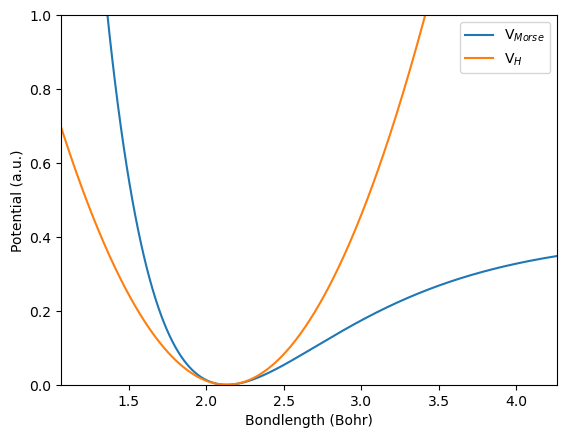

In [17]:
# plot the Morse potential and Harmonic approximation
plt.plot(r_array, V_Morse, label="V$_{Morse}$")
plt.plot(r_array, V_H, label="V$_{H}$")
plt.ylabel("Potential (a.u.)")
plt.xlabel("Bondlength (Bohr)")
plt.xlim(0.5 * r_eq, 2 * r_eq)
plt.ylim(0, 1)
plt.legend()
plt.show()

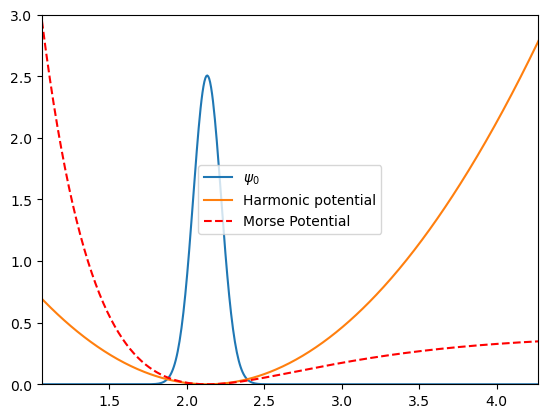

In [18]:
# compute alpha values in atomic units
alpha = compute_alpha(k, mu, 1)

# compute psi_0 along the r grid
psi_0 = psi(0, alpha, r_array, r_eq)

# is it normalized?
Integral = np.trapz(psi_0 ** 2, r_array)
assert np.isclose(Integral, 1.0)


# Harmonic potential
plt.plot(r_array, psi_0, label='$\psi_0$')
plt.plot(r_array, V_H, label="Harmonic potential")
plt.plot(r_array, V_Morse, 'r--', label="Morse Potential")
plt.xlim(0.5 * r_eq, 2 * r_eq)
plt.ylim(0, 3)
plt.legend()
plt.show()


In [19]:
# fundamental transition energy at HO level
fundamental_hf = harmonic_eigenvalue(1, k, mu, 1) - harmonic_eigenvalue(0, k, mu, 1)

## fundamental transition energy at Morse level
fundamental_Morse = morse_eigenvalue(1, k, mu, De, 1) - morse_eigenvalue(0, k, mu, De, 1)

# 1st order correction
pt1 = potential_matrix_element(0, 0, alpha, r_array, r_eq, (V_Morse - V_H))


# 2nd order correction
pt2 = 0

# sum over |<j|V'|n>|^2/(Ej-En)
for j in range(1, 50):
    E_j = harmonic_eigenvalue(j, k, mu, 1)
    Vc_j0 = potential_matrix_element(j, 0, alpha, r_array, r_eq, (V_Morse - V_H))
    pt2 += Vc_j0 ** 2 / (fundamental_hf - E_j)

          

In [20]:
au_to_wn = 219474.63068
print(fundamental_hf * au_to_wn)
print(pt1 * au_to_wn)
print(pt2 * au_to_wn)

2160.88567964685
5.765221903946544
-17.10708909811186


In [21]:
print((fundamental_hf + pt1 + pt2) * au_to_wn)
print(fundamental_Morse * au_to_wn)

2149.5438124526845
2134.6483144427093


In [25]:
m = np.linspace(-5, 5, 11, dtype=int)
m = np.delete(m, 5)
print(m)

[-5 -4 -3 -2 -1  1  2  3  4  5]


In [26]:
nu_vs_m = (fundamental_Morse + B0 * m) * au_to_wn

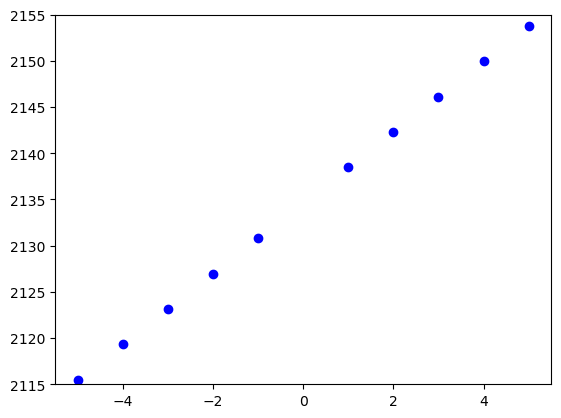

In [29]:
plt.plot(m, nu_vs_m, 'bo')
plt.ylim(2115, 2155)
plt.show()